# Hanami data in Japan


imports

In [385]:
from geopy.geocoders import Nominatim
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

### Read in Data

In [67]:
df = pd.read_csv("sakura_first_bloom_dates.csv")

### Before cleaning the data, let's add a few things. I want to know the location (lat and long) of each of these sites. let's use nominatim for that


In [70]:
geolocator = Nominatim(user_agent="japan_sites_geocoder")

city_name = "Wakkanai"

location = geolocator.geocode(city_name)

print("lat:", location.latitude, "long:", location.longitude)

latitudes = []
longitudes = []
for site in df["Site Name"]:
    location = geolocator.geocode(site, timeout=10000)
    if location:
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        print(f"{site}: {location.latitude}, {location.longitude}")
    else:
        latitudes.append("X")
        longitudes.append("X")

lat: 45.4158108 long: 141.6730309
Wakkanai: 45.4158108, 141.6730309
Rumoi: -4.7250782, 131.7316608
Asahikawa: 43.7627501, 142.3579263
Abashiri: 44.0206027, 144.2732035
Sapporo: 43.061936, 141.3542924
Iwamizawa: 43.1960638, 141.7753595
Obihiro: 42.923809, 143.1966324
Kushiro: 42.9906837, 144.3820381
Nemuro: 43.3301518, 145.5833876
Muroran: 42.3152461, 140.9740731
Urakawa: 42.1684998, 142.7680974
Esashi: 41.8690714, 140.1272235
Hakodate: 41.768793, 140.729008
Kutchan: 42.901741, 140.7590818
Monbetsu: 44.3565151, 143.3545224
Hiroo: 42.285532, 143.3116162
Shinjo: 38.7648577, 140.3021449
Aomori: 40.886943, 140.590121
Hachinohe: 40.5122388, 141.4882959
Akita: 39.6898802, 140.342608
Morioka: 39.7021331, 141.1545397
Miyako: 39.6395835, 141.9461177
Sakata: 38.9147229, 139.8364101
Yamagata: 38.4746705, 140.083237
Sendai: 38.2677554, 140.8691498
Fukushima: 37.760777, 140.4745807
Shirakawa: 37.1263397, 140.2107192
Onahama: 36.9383759, 140.8977807
Wajima: 37.3905644, 136.8994281
Aikawa: 35.532347, 

In [76]:
df.head()
df.insert(2, "lat", latitudes)
df.insert(3, "long", longitudes)

ValueError: cannot insert lat, already exists

In [78]:

df.head()

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,True,45.415811,141.673031,1953-05-21,1954-05-17,1955-05-17,1956-05-12,1957-05-18,1958-05-23,...,2016-05-13,2017-05-09,2018-05-12,2019-05-07,2020-05-10,2021-05-08,2022-05-06,2023-05-03,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,-4.725078,131.731661,1953-05-08,1954-05-11,1955-05-13,1956-05-08,1957-05-10,1958-05-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,43.76275,142.357926,1953-05-11,1954-05-13,1955-05-09,1956-05-07,1957-05-09,1958-05-10,...,2016-05-03,2017-05-03,2018-04-30,2019-05-01,2020-05-03,2021-04-29,2022-04-26,2023-04-25,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,44.020603,144.273203,1953-05-24,1954-05-16,1955-05-18,1956-05-09,NaN,NaN,...,2016-05-08,2017-05-05,2018-05-02,2019-05-05,2020-05-07,2021-05-06,2022-04-27,2023-04-28,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,43.061936,141.354292,1953-05-07,1954-05-04,1955-05-11,1956-05-04,1957-05-09,NaN,...,2016-04-25,2017-04-28,2018-04-26,2019-04-24,2020-04-30,2021-04-22,2022-04-23,2023-04-15,5 1,NaN


<Axes: xlabel='long', ylabel='lat'>

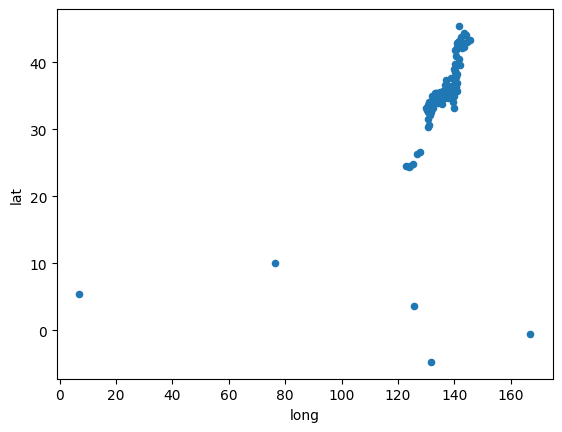

In [80]:
df["lat"] = pd.to_numeric(df["lat"], errors='coerce')
df["long"] = pd.to_numeric(df["long"], errors='coerce')

df.plot(kind="scatter", x="long", y="lat")
# plt.show()

So there's our map of japan, sort of! 

We still have to input some of the missing locations manually, but there are only three of them. I'm going to look those up and do them manually:

In [83]:
# df.info()
null_entries = df[df['lat'].isna()]
null_entries

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
73,Shio Misaki,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1958-03-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN
81,Mikihara,False,NaN,NaN,1953-03-28,1954-03-25,1955-03-26,1956-04-06,1957-04-05,1958-03-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN
101,Minami Daito Island,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-02-09,2017-01-27,2018-01-07,2019-01-25,2020-02-06,NaN,2022-01-28,2023-02-07,1 20,Taiwan cherry (Prunus campanulata)


In [85]:
#minami daito

df.loc[101, 'lat'] =25.8288
df.loc[101, 'long'] =131.2321

# shio misaki is (i am assuming) shio no misaki
df.loc[73, 'lat'] =33.3883
df.loc[73, 'long'] =135.5667

#mikihara
# I couldn't find anywhere called mikihara in japan, and there are too many
# similar-sounding names (makihara, makinohara, mitakihara, etc) so i will drop this one
df.drop(81, inplace=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 101
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Name                  101 non-null    object 
 1   Currently Being Observed   101 non-null    bool   
 2   lat                        101 non-null    float64
 3   long                       101 non-null    float64
 4   1953                       78 non-null     object 
 5   1954                       80 non-null     object 
 6   1955                       81 non-null     object 
 7   1956                       83 non-null     object 
 8   1957                       82 non-null     object 
 9   1958                       82 non-null     object 
 10  1959                       85 non-null     object 
 11  1960                       84 non-null     object 
 12  1961                       85 non-null     object 
 13  1962                       87 non-null     object 
 14 

The format for the date isn't quite right here; we want an int representing the day of the year, not a stirng version of the date:

In [90]:
#takes date string and returns day of year
def get_day_of_year(datestr):
    # print(datestr)
    try:
        return datetime.datetime.strptime(datestr, "%Y-%m-%d").timetuple().tm_yday
    except:
        return None

def fix_column(col):
    days = []
    for date in col:
        days.append(get_day_of_year(date))
    return days
        

In [92]:
normalized_hanami = df.copy()
normalized_hanami.iloc[:,4:75] = df.iloc[:, 4:75].apply(fix_column)

In [94]:
normalized_hanami.head()

,Site Name,Currently Being Observed,lat,long,1953,1954,1955,1956,1957,1958,...,2016,2017,2018,2019,2020,2021,2022,2023,30 Year Average 1981-2010,Notes
0,Wakkanai,True,45.415811,141.673031,141.0,137.0,137.0,133.0,138.0,143.0,...,134.0,129.0,132.0,127.0,131.0,128.0,126.0,123.0,5 13,Sargent cherry (Prunus sargentii)
1,Rumoi,False,-4.725078,131.731661,128.0,131.0,133.0,129.0,130.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Sargent cherry (Prunus sargentii)
2,Asahikawa,True,43.762750,142.357926,131.0,133.0,129.0,128.0,129.0,130.0,...,124.0,123.0,120.0,121.0,124.0,119.0,116.0,115.0,5 4,Sargent cherry (Prunus sargentii)
3,Abashiri,True,44.020603,144.273203,144.0,136.0,138.0,130.0,NaN,NaN,...,129.0,125.0,122.0,125.0,128.0,126.0,117.0,118.0,5 10,Sargent cherry (Prunus sargentii)
4,Sapporo,True,43.061936,141.354292,127.0,124.0,131.0,125.0,129.0,NaN,...,116.0,118.0,116.0,114.0,121.0,112.0,113.0,105.0,5 1,NaN


Now we have the day of the year instead of a date string listed! We just have to make them numeric.

In [97]:
normalized_hanami.iloc[:, 4:75] = normalized_hanami.iloc[:, 4:75].apply(pd.to_numeric, errors='coerce')

In [99]:
for col in normalized_hanami.iloc[:, 4:75]:
    # print(col)
    normalized_hanami[col] = pd.to_numeric(normalized_hanami[col], errors='coerce')

In [106]:
normalized_hanami.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 101
Data columns (total 78 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Site Name                  101 non-null    object 
 1   Currently Being Observed   101 non-null    bool   
 2   lat                        101 non-null    float64
 3   long                       101 non-null    float64
 4   1953                       78 non-null     float64
 5   1954                       80 non-null     float64
 6   1955                       81 non-null     float64
 7   1956                       83 non-null     float64
 8   1957                       82 non-null     float64
 9   1958                       82 non-null     float64
 10  1959                       85 non-null     float64
 11  1960                       84 non-null     float64
 12  1961                       85 non-null     float64
 13  1962                       87 non-null     float64
 14 

### 

### Melt the data

The way the dataset is organized isn't going to do us any favors; right now, there are ~100 rows representing sites, and ~75 columns representing years; we want to transform the shape of this data so that each row represents a record, and the columns would be information about that record: the site name, the lat/long, the day of the year, and the year. This would also rid us of much of the NaN values for the years where the hanami wasn't recorded at a give site

SO, to do this, we want to "melt" the dataframe. first, we'll get rid of some of the columns we don't need (like 30 year average, etc). Then we'll call the .melt() method to split the row into multiple entries:

After using pd.melt(), each original row (representing one location) will be split into multiple rows — one for each year.

For example, if you currently have a single row for a location with columns for years (e.g., 2001, 2002, 2003), this row will be "melted" into multiple rows: one for each year with corresponding day_of_year values. The final structure will look like this:

|location	|year|	day_of_year|
---|---|---|
|Location1|2001|	95|
|Location1	|2002	|102|
|Location1|	2003	|87|
|Location2|	2001	|105|
|...|	...|	...|
What was one row for each location will now be many rows — one per year for each location.

In [110]:
# Get rid of unnecessary (for now) data
normalized_hanami = normalized_hanami.drop(
    [
        '30 Year Average 1981-2010', 
        'Currently Being Observed',  
        "average"],
    axis=1)
    

### Time to melt:

In [122]:
melted_data = pd.melt(normalized_hanami, id_vars=[ 'lat', 'long', 'Site Name', "Notes"], var_name='year',value_name='day_of_year')
melted_data.head()

,lat,long,Site Name,Notes,year,day_of_year
0,45.415811,141.673031,Wakkanai,Sargent cherry (Prunus sargentii),1953,141.0
1,-4.725078,131.731661,Rumoi,Sargent cherry (Prunus sargentii),1953,128.0
2,43.762750,142.357926,Asahikawa,Sargent cherry (Prunus sargentii),1953,131.0
3,44.020603,144.273203,Abashiri,Sargent cherry (Prunus sargentii),1953,144.0
4,43.061936,141.354292,Sapporo,NaN,1953,127.0


And that looks right to me! This is going to make life much easier.

now we have to get rid of any entries that don't have a record for the day of the year, and make sure that the year column is numeric

In [125]:
cleaned = melted_data.dropna(subset=["day_of_year"])

cleaned["year"] = pd.to_numeric(cleaned["year"], errors='coerce')

cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6075 entries, 0 to 7170
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lat          6075 non-null   float64
 1   long         6075 non-null   float64
 2   Site Name    6075 non-null   object 
 3   Notes        1089 non-null   object 
 4   year         6075 non-null   int64  
 5   day_of_year  6075 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 332.2+ KB


/var/folders/0c/77zvfgcx7_x9dcfzd5cdgqlw0000gn/T/ipykernel_50459/3754745707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned["year"] = pd.to_numeric(cleaned["year"], errors='coerce')


Great -- we got a warning here, but it looks great. We've reshaped the data and gotten rid of NaN values (except for notes, which are optional).

let's take a look:

<Axes: xlabel='year', ylabel='day_of_year'>

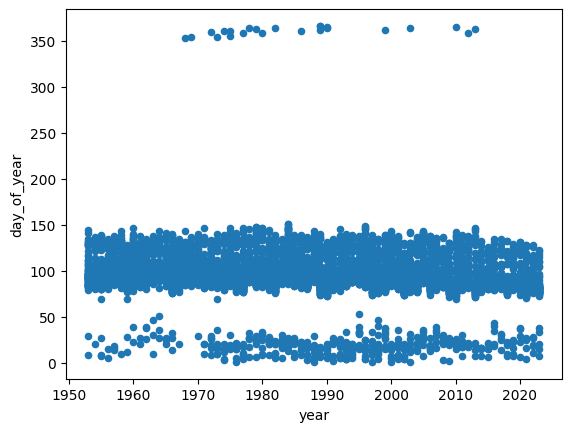

In [142]:
cleaned.plot(kind="scatter",x="year", y="day_of_year")

It looks like in a few cases, the first bloom was in december (likely in okinawa). this is making it look like there was a very late bloom, when it was actually a very early bloom! we should massage this to show that (so, if the first bloom was december 25, it should be day of year = -6 instead of 350).

In [150]:
def normalize_day(day):
    if day > 300:
        day = day-356
    return day

normalized_df = cleaned.copy()
normalized_df['day_of_year'] =cleaned['day_of_year'].apply(normalize_day)

<Axes: xlabel='year', ylabel='day_of_year'>

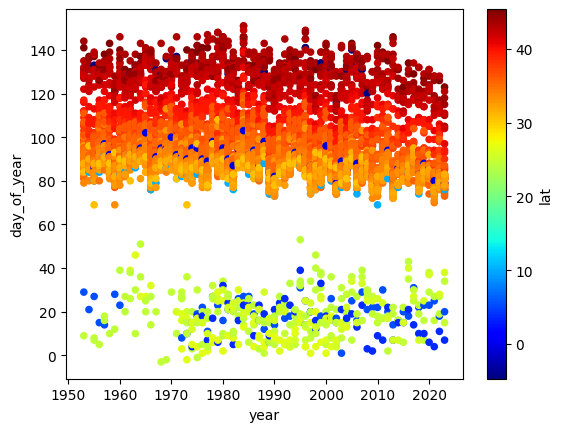

In [152]:
normalized_df.plot(kind="scatter",x="year", y="day_of_year", c="lat", cmap="jet")

And that is what we are looking for!

### Time to create a training/test set

We want to make sure that both our test set and our training set have a decent spread of target (in this case, our target is the day of first sakura bloom). 

Let's add a column that we can use to get an even spread

In [159]:
normalized_df['first_bloom_cat'] = pd.cut(
    normalized_df['day_of_year'],
    bins=[ -10, 20, 50, 80 ,110, np.inf],
    labels=[1,2,3,4,5]
)

Let's take a look:

<Axes: xlabel='first_bloom_cat'>

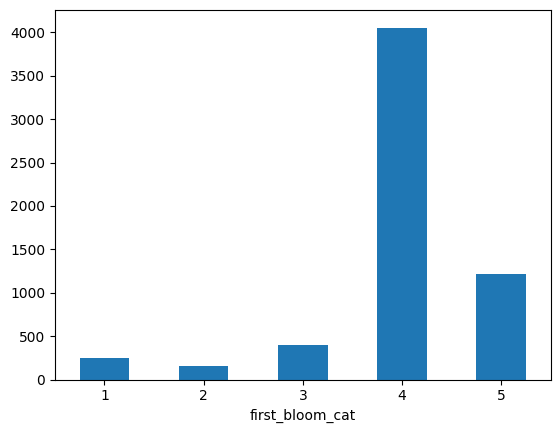

In [163]:
normalized_df['first_bloom_cat'].value_counts().sort_index().plot.bar(rot=0)


Time to make the split:

In [173]:
strat_train_set, strat_test_set = train_test_split(
    normalized_df, test_size=0.2, random_state=17, stratify=normalized_df["first_bloom_cat"])

print("lenth of training set:",len(strat_train_set))
print("proportions:", strat_train_set["first_bloom_cat"].value_counts())

lenth of training set: 4860
proportions: first_bloom_cat
4    3244
5     974
3     320
1     200
2     122
Name: count, dtype: int64


And there we have it. now we have a training set and test set that are representative of the original data. We think. Let's get rid of the category column; it was meant to be temporary.

In [175]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("first_bloom_cat", axis=1, inplace=True)

In [177]:
strat_train_set.head()

,lat,long,Site Name,Notes,year,day_of_year
6904,35.926350,136.606813,Fukui,NaN,2021,81.0
4924,34.342559,134.046534,Takamatsu,NaN,2001,85.0
2183,35.544674,134.820113,Toyooka,NaN,1974,97.0
6329,34.391724,132.451759,Hiroshima,NaN,2015,83.0
5961,43.762750,142.357926,Asahikawa,Sargent cherry (Prunus sargentii),2012,123.0


### Let's do some more visualizations!


In [204]:
hanami = strat_train_set.copy()

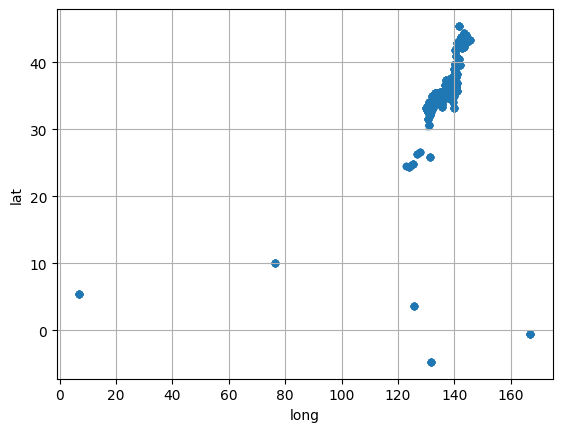

In [206]:
hanami.plot(kind="scatter", x="long", y="lat", grid=True, alpha=.2)
plt.show()

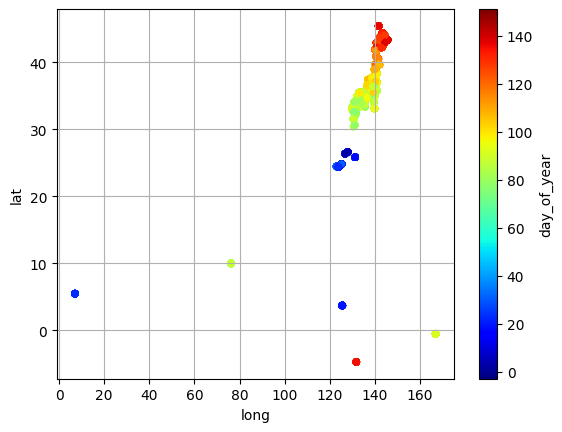

In [208]:
hanami.plot(kind="scatter", x="long", y="lat", grid=True,
           c='day_of_year', cmap="jet")
plt.show()

#### AMAZING. 

Now we have a visualization of when geographically the hanami bloom. it is as expected: the farther north, the later the bloom (with a few outliers, of course).Let's see about some correlations!

In [211]:
corr_matrix = hanami.drop(columns = ["Site Name","Notes"]).corr()

In [213]:
corr_matrix["day_of_year"].sort_values(ascending=False)

day_of_year    1.000000
lat            0.557889
long           0.475557
year          -0.160529
Name: day_of_year, dtype: float64

So what do we have here? Generally, the higher your lat, the later in the year for the first bloom. additionally, we have a slight negative correlation between the year and the day of first bloom; this means that (generally) the day of first bloom gets earlier as the years go on.

array([[<Axes: xlabel='day_of_year', ylabel='day_of_year'>,
        <Axes: xlabel='year', ylabel='day_of_year'>,
        <Axes: xlabel='lat', ylabel='day_of_year'>,
        <Axes: xlabel='long', ylabel='day_of_year'>],
       [<Axes: xlabel='day_of_year', ylabel='year'>,
        <Axes: xlabel='year', ylabel='year'>,
        <Axes: xlabel='lat', ylabel='year'>,
        <Axes: xlabel='long', ylabel='year'>],
       [<Axes: xlabel='day_of_year', ylabel='lat'>,
        <Axes: xlabel='year', ylabel='lat'>,
        <Axes: xlabel='lat', ylabel='lat'>,
        <Axes: xlabel='long', ylabel='lat'>],
       [<Axes: xlabel='day_of_year', ylabel='long'>,
        <Axes: xlabel='year', ylabel='long'>,
        <Axes: xlabel='lat', ylabel='long'>,
        <Axes: xlabel='long', ylabel='long'>]], dtype=object)

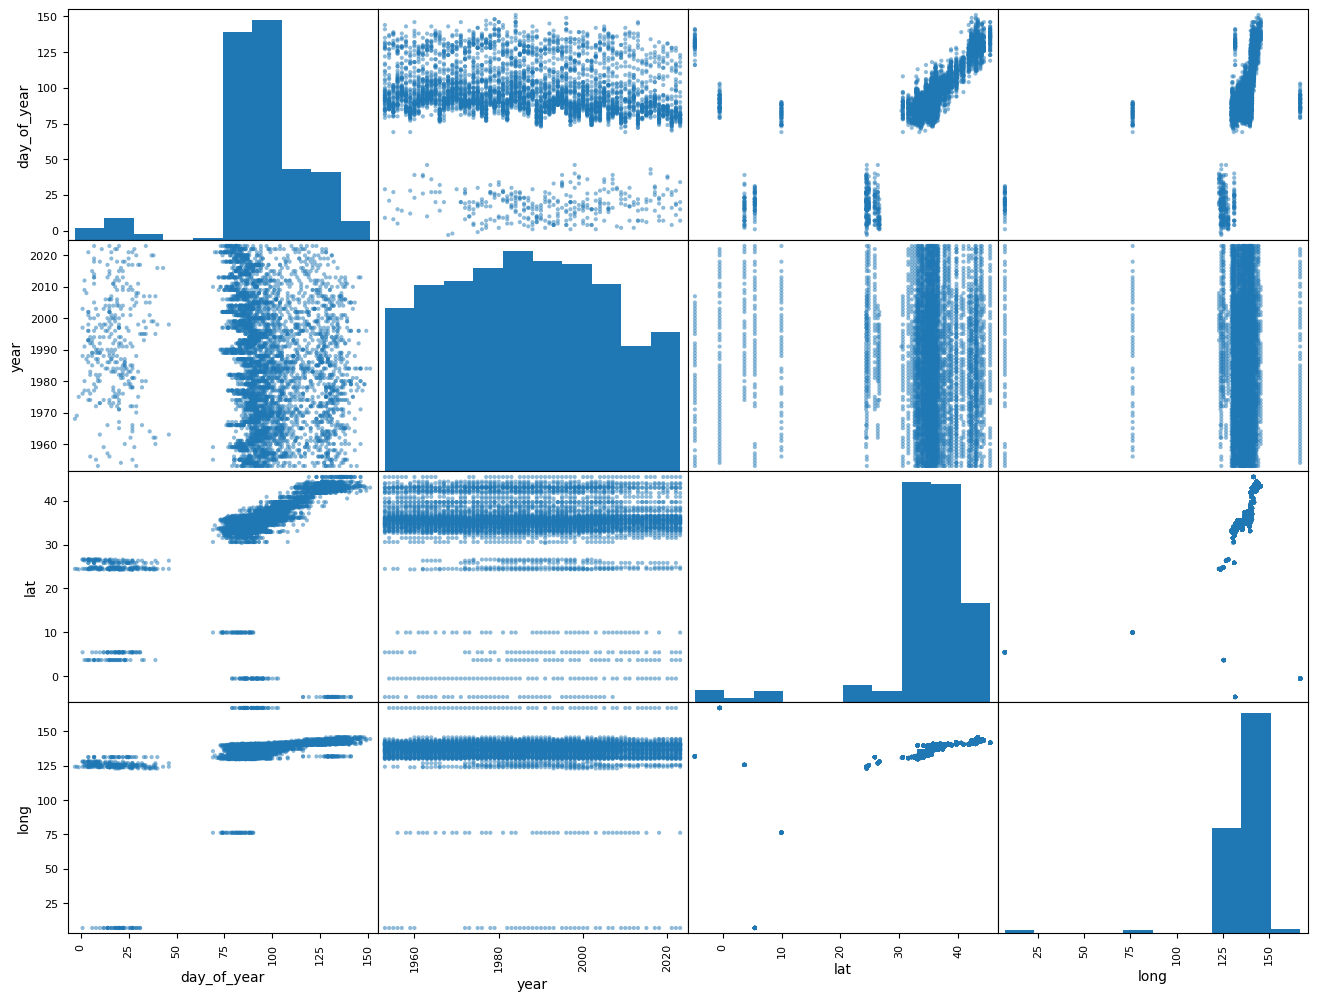

In [224]:
attributes = [ "day_of_year", "year", "lat", "long"]

scatter_matrix(hanami[attributes], figsize=(16,12))

Honestly, it's pretty hard to see anything from these scatter plots

# Prep your data!

### Separate the data:

Before we go any further, we want to separate the features (lat, long, and year) from the target/label (day of year)

In [424]:
sakura = strat_train_set.drop("day_of_year", axis=1)
sakura_labels = strat_train_set["day_of_year"].copy()

### Clean the data

Now is when we would impute some of the missing values, but there aren't any in the data set anymore (aside from notes, which is fine). We could do this by dropping those records, or if possible and appropriate, fill with the mean for that column.

We could also use something more powerful than just the mean here; `KNNImputer` will replace missing values with the mean of just the k nearest neighbors (based on all available features).

OR, we could use `IterativeImputer`, which trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration. So cool.

### Feature Scaling

Now it's time to scale these features -- just the numeric ones, so that they all have just about the same impact on the overall graphs.

We will use standardization here. Standardization first subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standardized values have a standard deviation equal to 1). It is less affected by outliers than something like min-max scaling.

In [430]:
std_scaler = StandardScaler()

# get the numeric features only
sakura_num = sakura.drop(["Site Name", "Notes"], axis=1)
sakura_num_std_scaled = std_scaler.fit_transform(sakura_num)

Our scaler will give us a 2d array, which we need to turn back into a Dataframe if we want to keep using these functions on it:

In [437]:
sakura_scaled_df = pd.DataFrame(sakura_num_std_scaled,columns=sakura_num.columns, index=sakura.index)

sakura_scaled_df.info()
sakura.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 6904 to 2362
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     4860 non-null   float64
 1   long    4860 non-null   float64
 2   year    4860 non-null   float64
dtypes: float64(3)
memory usage: 280.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 6904 to 2362
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        4860 non-null   float64
 1   long       4860 non-null   float64
 2   Site Name  4860 non-null   object 
 3   Notes      878 non-null    object 
 4   year       4860 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 356.9+ KB


Then, let's add the non-numeric columns back in (let's rename them while we're at it)

In [449]:
sakura_scaled_df["site"] = sakura["Site Name"]
sakura_scaled_df["notes"] = sakura["Notes"]

In [447]:
sakura["Site Name"].value_counts().sort_index()

Site Name
Abashiri           53
Aikawa             45
Akita              55
Aomori             51
Asahikawa          55
                   ..
Yakushima           1
Yamagata           59
Yokohama           58
Yonago             42
Yonaguni Island    13
Name: count, Length: 101, dtype: int64

### Pipelines

We can combine all the steps we need to do before we train our system; to do that, we create a "pipeline". this is essentially a list of steps and processes your data goes through; you out line it and can then use it on any data set (training, test, new batches, etc!)

Let's make a pipeline for numerical attributes:


In [271]:
numeric_pipeline = Pipeline([
    # can put a lot of things in here; anyting that's a transformer
    # (anything that has a .fit_transform method.
    # might be nice to create our own function that melts the data.
    # for now, we'll just standardize it
    # ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

#### Now we can fit this pipeline and transform some data:

In [359]:
sakura_num_prepared = numeric_pipeline.fit_transform(sakura_num)

Turn it back into a DF:

In [372]:
sakura_num_prepared_df = pd.DataFrame(
    sakura_num_prepared, columns=numeric_pipeline.get_feature_names_out(),
    index=sakura_num.index)

But we're still missing a site and notes; we can make our own pipeline for those columns as well (in this case we do nothing), and then combine them into a column transformer:

In [383]:
category_pipeline = Pipeline([
    #we would put transformers in here
    # but in this case we don't need any
])

In [387]:
preprocessing = make_column_transformer(
    (numeric_pipeline, make_column_selector(dtype_include=np.number)),
    (category_pipeline, make_column_selector(dtype_include=object)),
)

^^ This makes a column transformer, which will separate the columns by type and send the numeric columns through the numeric pipline and the rest through the category pipeline

So let's get some fresh data and try it out:

In [394]:
sakura = strat_train_set.copy()

#won's actually work because we have no steps in category pipeline
sakura_prepared = preprocessing.fit_transform(sakura) 

TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. 'Pipeline(steps=[])' (type <class 'sklearn.pipeline.Pipeline'>) doesn't.

In [441]:
sakura_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 6904 to 2362
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     4860 non-null   float64
 1   long    4860 non-null   float64
 2   year    4860 non-null   float64
dtypes: float64(3)
memory usage: 280.9 KB


# SELECT AND TRAIN THE MODEL

let's try a linear regression first.

In [ ]:
# scaled_hanami_df

lin_reg = LinearRegression()
lin_reg.fit(scaled_hanami_df.drop(["site","note"], axis=1), sakura_labels)

In [ ]:
pred = lin_reg.predict(scaled_hanami_df.drop(["site", "note"],axis=1))

Let's try and visualize it:

In [ ]:
import matplotlib.pyplot as plt
# plt.scatter(scaled_hanami_df.drop(["site","note"], axis=1), sakura_labels, color='blue', label='Data points')

# Plot the regression line
plt.plot(scaled_hanami_df.drop(["site","note"], axis=1), pred, color='red', label='Regression line')

# Add labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

## Not quite what I had in mind....

In [ ]:
len(sakura_labels)

In [ ]:
pred[:5]


In [ ]:
sakura_labels.iloc[:5].values

In [ ]:
lin_rmse = mean_squared_error(sakura_labels, pred, squared=False)

In [ ]:
lin_rmse


so what does this mean? It means our linear regression is off by, on average, about 20 days. not so great!! but this is just a linear regression; there's a lot going on here, our data set is quite small truly, and there's a lot more that could be done here.

OK, so we wanna test it out -- find the lat and long for fukuoka, make an array of different years:

In [ ]:
test_data = {
    "lat":[33.5902, 33.5902, 33.5902, 33.5902],
    "long":[130.4017, 130.4017, 130.4017, 130.4017],
    "year":[1960, 1990, 2024, 2524]
}

test_df = pd.DataFrame(test_data, columns= ["lat", "long", "year"])

test_df

scale it:

In [ ]:
scaled_test = std_scaler.transform(test_df)
scaled_df = pd.DataFrame(scaled_test, columns= ["lat", "long", "year"])
scaled_df

now let's run it through the model:

In [ ]:
test_predictions = lin_reg.predict(scaled_df)
test_predictions

#### Ok!!! Now we're onto something. it guessed this year would be the ~84th day (March 25th), when it was actually March 27th -- it's off, but it's close!. The interesting thing is it does seem to have found a trend; it predicted that in 500 years it would be in January.

Let's try the same thing, with a wider range of years in fukuoka, and then one in hokkaido:

In [ ]:
test_fuk = {
    "lat":[33.5902, 33.5902, 33.5902, 33.5902],
    "long":[130.4017, 130.4017, 130.4017, 130.4017],
    "year":[1000, 1900, 2024, 3524]
}

fuk_df = pd.DataFrame(test_fuk, columns= ["lat", "long", "year"])

## Wakkanai

test_wak = {
    "lat":[45.4156, 45.4156, 45.4156, 45.4156],
    "long":[141.6734, 141.6734, 141.6734, 141.6734],
    "year":[1960, 1990, 2024, 2524]
}

wak_df = pd.DataFrame(test_wak, columns= ["lat", "long", "year"])

scaled_fuk = std_scaler.transform(fuk_df)
fuk = pd.DataFrame(scaled_fuk, columns= ["lat", "long", "year"])
scaled_wak = std_scaler.transform(wak_df)
wak = pd.DataFrame(scaled_wak, columns= ["lat", "long", "year"])


In [ ]:
lin_reg.predict(fuk)

In [ ]:
lin_reg.predict(wak)

the one for hokkaido is more off: It guessed the first bloom would be the 105th day (April 14) when it was actually the 124(May 4th). That said, it is picking up on that same trend of it being earlier, and the trend of it being later on average in wakkanai than fukuoka. nice!

Let's try out a different model:

In [ ]:
knr = KNeighborsRegressor()

In [ ]:
knr.fit(scaled_hanami_df.drop(["site","note"], axis=1), sakura_labels)

In [ ]:
knr.predict(scaled_hanami_df.drop(["site","note"], axis=1))

In [ ]:
knr.predict(fuk)

In [ ]:
knr.predict(wak)